## Project 07
### Grasell (May 17, 2021)

In [1]:
# Import libraries that might be used in the project

import os
import cv2 as cv2
from pathlib import Path
import random
from google.colab.patches import cv2_imshow
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold, train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, load_img
import tensorflow as tf

In [2]:
# Connect to Google Drive

from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/content/gdrive/My Drive/Github/AML/Project07/facesDB


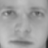

In [3]:
# Move to the facesDB working directory and verify by displaying the first face

%cd /content/gdrive/My Drive/Github/AML/Project07/facesDB

a = cv2.imread("1/1.BMP")
cv2_imshow(a)

In [4]:
# Define some constants to be used later

FAST_RUN = False
IMAGE_WIDTH= 48
IMAGE_HEIGHT= 48
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
input_path = ''

In [5]:
# Create a dataframe with filenames and category.
# Verify dataframe created successfully

df = pd.DataFrame({'filename': list(Path(input_path).glob('**/*.BMP'))})
df['category'] = df['filename'].map(lambda x: x.parent.stem)
df['filename'] = df['filename'].map(lambda x: str(x))

df.head()

,filename,category
0,1/6.BMP,1
1,1/7.BMP,1
2,1/8.BMP,1
3,1/2.BMP,1
4,1/3.BMP,1


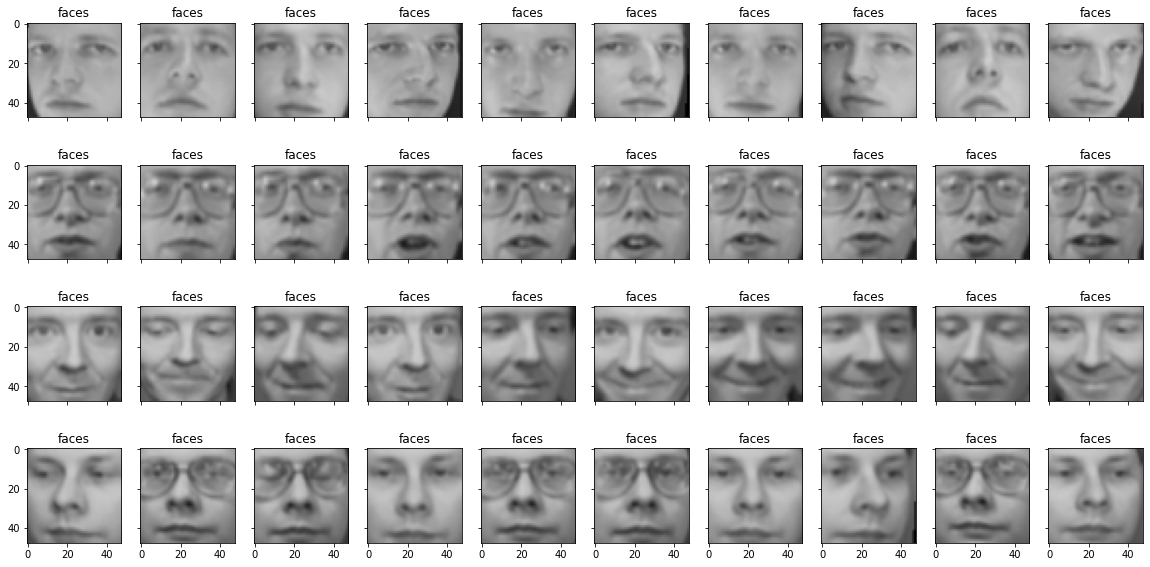

In [6]:
# Plot the first 4 individuals (10 faces each) to verify correct data import

fig, ax = plt.subplots(nrows=4, ncols=10, sharex=True, sharey=True, figsize=(20,10))

ax = ax.flatten()

for i in range(40):
    img = cv2.imread(df['filename'][i])
    ax[i].imshow(img)
    ax[i].set_title('faces')
    
plt.show()

In [7]:
# Set up the CNN Sequencial Model

model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2)) # for dimensionality reduction

model.add(Conv2D(512, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2))) # for dimensionality reduction

model.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2))) # for dimensionality reduction

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))

model.add(Dense(40, activation='softmax'))

opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 512)       295424    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 512)       2048      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 512)       2359808   
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 512)       2

In [8]:
# Recode category into subjects (ie S1 is subject 1 etc.)

df["category"] = df["category"].replace({1: 'S1', 2: 'S2', 3: 'S3', 4: 'S4', 5: 'S5', 6: 'S6', 7: 'S7', 8: 'S8', 9: 'S9', 10: 'S10',
                                         11: 'S11', 12: 'S12', 13: 'S13', 14: 'S14', 15: 'S15', 16: 'S16', 17: 'S17', 18: 'S18', 19: 'S19', 20: 'S20',
                                         21: 'S21', 22: 'S22', 23: 'S23', 24: 'S24', 25: 'S25', 26: 'S26', 27: 'S27', 28: 'S28', 29: 'S29', 30: 'S30',
                                         31: 'S31', 32: 'S32', 33: 'S33', 34: 'S34', 35: 'S35', 36: 'S36', 37: 'S37', 38: 'S38', 39: 'S39', 40: 'S40'}) 

In [9]:
# Split the data into train and validation sets
# The split had to make sure that both datasets had at least 1 face sample from each subject

train_df, validate_df = train_test_split(df, test_size=0.35, random_state=64)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

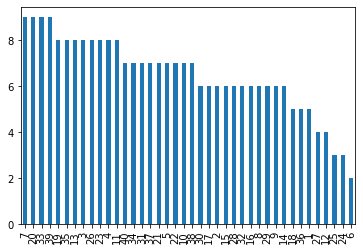

In [10]:
# Verify the distribution of subject faces in the train_df

train_df['category'].value_counts().plot.bar()

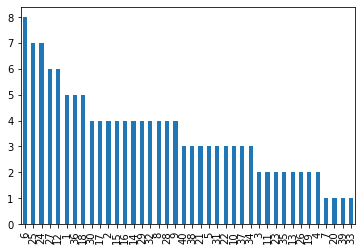

In [11]:
# Verify the distribution of subject faces in the validate_df

validate_df['category'].value_counts().plot.bar()

In [12]:
# Capture shape details

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=1

In [13]:
# Rescale images from 0-255 to 0-1
# Generate final images for analysis

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 260 validated image filenames belonging to 40 classes.
Found 140 validated image filenames belonging to 40 classes.


In [14]:
# Run the CNN with 13 epochs.
# Epochs from 3 to 100 were evaluated
# 9 to 13 epochs performed best with this CNN model

epochs=13
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size
)

Epoch 1/13


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


260/260 [==============================] - 6s 12ms/step - loss: 6.8282 - accuracy: 0.0104 - val_loss: 3.7427 - val_accuracy: 0.0286
Epoch 2/13
260/260 [==============================] - 3s 10ms/step - loss: 4.0547 - accuracy: 0.1087 - val_loss: 4.1315 - val_accuracy: 0.0929
Epoch 3/13
260/260 [==============================] - 3s 10ms/step - loss: 3.3727 - accuracy: 0.1914 - val_loss: 4.2649 - val_accuracy: 0.1786
Epoch 4/13
260/260 [==============================] - 3s 10ms/step - loss: 2.6316 - accuracy: 0.3094 - val_loss: 3.4654 - val_accuracy: 0.2214
Epoch 5/13
260/260 [==============================] - 3s 10ms/step - loss: 1.9262 - accuracy: 0.5087 - val_loss: 2.8635 - val_accuracy: 0.3429
Epoch 6/13
260/260 [==============================] - 3s 11ms/step - loss: 1.4789 - accuracy: 0.6221 - val_loss: 3.8383 - val_accuracy: 0.3500
Epoch 7/13
260/260 [==============================] - 3s 10ms/step - loss: 1.1476 - accuracy: 0.7469 - val_loss: 3.1027 - val_accuracy: 0.4143
Epoch 8/13

In [15]:
# Save the weights from the final CNN model

model.save_weights("model.h5")

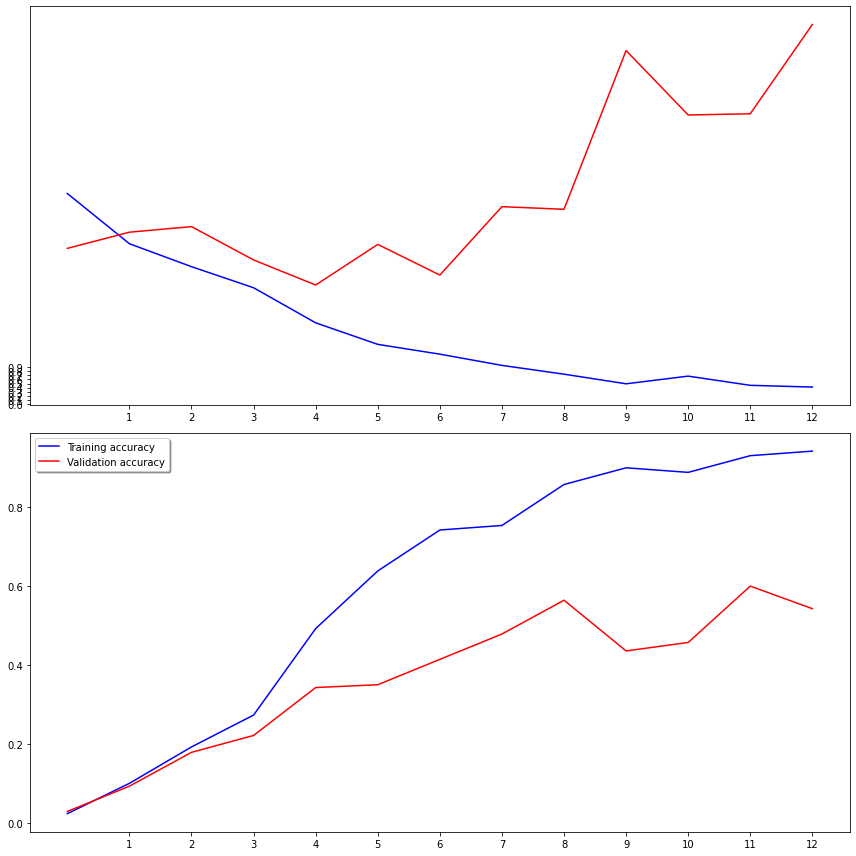

In [16]:
# Plot training/validation loss in top graph
# Plot training/validation accuracy in bottem plot

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()


## Summary

* I struggled to get the data read and formatted correctly to run the CNN models. This took several days of research and trial and error.
* The directions stated that the images were 48 x 48 with 3 channels. This was confusing since the channels represent colors and these images are grayscale. The CNN model might perform better if the images were reduced to 1 channel.
* The final model accuracy for the training data approached 97%
* The loss plot shows that loss was continuous for the training data, but started to increase after 4 epochs for the validation data.
* The accuracy for the training data continuously increase to a maximun of about 97%, but the accuracy for the validation data declined after 8 epochs
* Based on multiple runs it is determined that between 9 and 13 epochs are optimal for this data and CNN model.
* One reason that this model did not perform well is because of the distribution of faces in the training dataset. There were 8 subjects that had 5 or less faces in the training set. These faces were not learned well and these same subjects had 5 or more faces in the validation set.
* I investigated using image generation (ImageDataGenerator) to generate additional samples to help solve the problem with small sampling, but I did not have time to fully understand and implement this functionality. ImageDataGenerator is very powerful in that it allows rotations, rescale, axis flips and many other transformations.